<a href="https://colab.research.google.com/github/c-c-c-c/matsu_lab/blob/master/book_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !ls
# os.listdir( "/content/drive/My Drive/Colab Notebooks/book/")
# # os.listdir( "/content/drive/My\ Drive/data/Colab\ Notebooks/")

In [0]:
import os
import math
import datetime
import json
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import cv2
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
%matplotlib inline

# 追記

## main

In [0]:
# 読み込み
# org_img = cv2.imread("./source/book.jpg")
# org_img = cv2.imread("./source/book4.jpg")

org_img = cv2.imread("/content/drive/My Drive/Colab Notebooks/授業/book/book.jpg")
img_height = org_img.shape[0]
img_width = org_img.shape[1]
img_center = (int(img_width/2), int(img_height/2))


In [0]:
# 白黒
gray_img = cv2.cvtColor(org_img , cv2.COLOR_BGR2GRAY)
# 2値化
_, gray_img = cv2.threshold(gray_img, 125, 255, cv2.THRESH_BINARY)
#ケニー処理 結局使わなかった
c_img = cv2.Canny(gray_img, 10, 255)

In [0]:
# 輪郭認識
# contours, hierarchy = cv2.findContours(c_img,  cv2.RETR_LIST,  cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(gray_img,  cv2.RETR_LIST,  cv2.CHAIN_APPROX_SIMPLE)

In [0]:
area_size=[ ]

for i in range(0, len(contours)):
    area_size.append([contours[i],cv2.contourArea(contours[i])])

area_size.sort(key=lambda x: x[1], reverse=True)

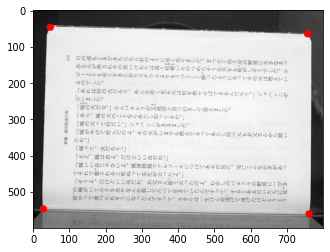

In [0]:
# なぜかarea_sizeで最も大きいはずの一番外側が出てこない
# これで四つ角がとれる idxで大きい順
idx = 0
epsilon = 0.1 * cv2.arcLength( area_size[idx][0], True )
approx = cv2.approxPolyDP( area_size[idx][0], epsilon, True )
tst_img = org_img.copy()
cv2.drawContours(tst_img, approx, -1,(0, 0, 255),20)

im4p = cv2.cvtColor(tst_img, cv2.COLOR_BGR2RGB)
plt.imshow(im4p)

In [0]:
side_point_dict = {}
for tmp_point in approx:
    if img_center[0] < tmp_point[0][0]:
        if img_center[1] < tmp_point[0][1]:
            side_point_dict["right_down"] = tmp_point
        else:
            side_point_dict["right_up"] = tmp_point
            
    else :
        if img_center[1] < tmp_point[0][1]:
            side_point_dict["left_down"] = tmp_point
        else:
            side_point_dict["left_up"] = tmp_point
        

In [0]:
side_point_dict

{'left_down': array([[ 28, 547]], dtype=int32),
 'left_up': array([[47, 47]], dtype=int32),
 'right_down': array([[761, 561]], dtype=int32),
 'right_up': array([[757,  65]], dtype=int32)}

In [0]:
# print("x",x,"y",y,"w",w,"h",h)

In [0]:
# 座標の対応に注意して、数を合わせる
perspective1 = np.float32([side_point_dict["left_down"],
                           side_point_dict["right_down"],
                           side_point_dict["right_up"],
                           side_point_dict["left_up"] ])

x,y,w,h = cv2.boundingRect(area_size[0][0])
# perspective2 = np.float32([[y, x],[y, x+w], [y+h, x+h],[y+h, x]]) # 逆にしたけど、、
perspective2 = np.float32([[x, y+h],[x+w, y+h], [x+w, y],[x, y]])

psp_img = cv2.getPerspectiveTransform(perspective1,perspective2)
img_psp = cv2.warpPerspective(tst_img, psp_img,(x+w,h+y))

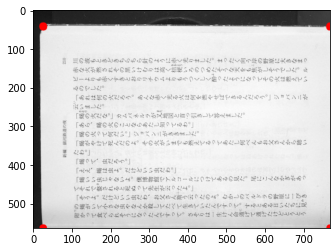

In [0]:
im4p = cv2.cvtColor(img_psp, cv2.COLOR_BGR2RGB)
plt.imshow(im4p)

## 矩形・回転 

In [0]:
rct_img = img_psp[y : y+h, x : x+w]

rct_rtt_img = cv2.rotate(rct_img, cv2.ROTATE_90_CLOCKWISE)

## 以下、様々な表示チェック

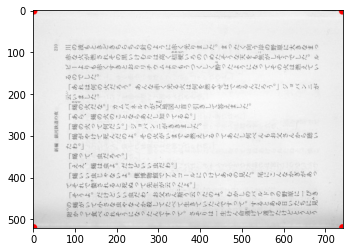

In [0]:
# plt.imshow(rct_rtt_img)
im4p = cv2.cvtColor(rct_img, cv2.COLOR_BGR2RGB)
plt.imshow(im4p)

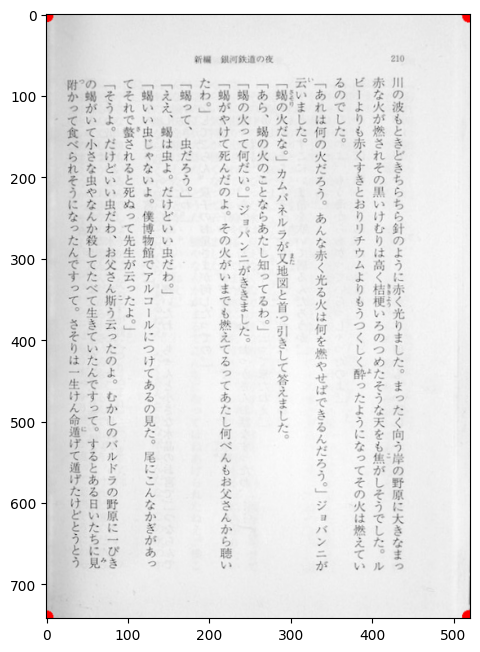

In [0]:
# plt.imshow(rct_rtt_img)
im4p = cv2.cvtColor(rct_rtt_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(im4p)

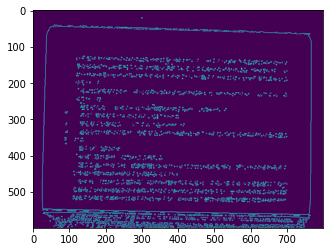

In [0]:
# ケニー化
plt.imshow(c_img)
plt.show()

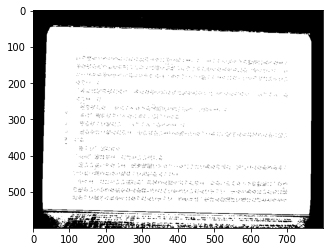

In [0]:
#  2値化の結果
im4p = cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)
plt.imshow(im4p)
plt.show()

## OCR 機能


In [0]:
# 日本語は縦書きの分も入れる (vertがついているもの)
!apt install tesseract-ocr tesseract-ocr-script-jpan tesseract-ocr-jpn-vert  tesseract-ocr-script-jpan-vert
!apt install libtesseract-dev
!pip install pyocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following NEW packages will be installed:
  tesseract-ocr-jpn-vert tesseract-ocr-script-jpan
  tesseract-ocr-script-jpan-vert
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 7,565 kB of archives.
After this operation, 15.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-jpn-vert all 4.00~git24-0e00fe6-1.2 [1,888 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-script-jpan all 4.00~git24-0e00fe6-1.2 [2,585 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-script-jpan-vert all 4.00~git24-0e00fe6-1.2 [3,092 kB]
Fetched 7,565 kB in 1s (6,178 kB/s)
Selecting previously unselected package tesseract-ocr-jpn-vert.
(Reading database ... 144625 files and directories currentl

In [0]:
# バージョンによって場所が違うので注意
!curl -L https://github.com/tesseract-ocr/tessdata/raw/master/jpn.traineddata > jpn.traineddata
!cp jpn.traineddata /usr/share/tesseract-ocr/4.00/tessdata/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   145  100   145    0     0    783      0 --:--:-- --:--:-- --:--:--   783
100 34.0M  100 34.0M    0     0  34.7M      0 --:--:-- --:--:-- --:--:--  132M


In [0]:
from PIL import Image
import sys
import pyocr
import pyocr.builders

In [0]:
#OCRが使用可能かをチェック
tools = pyocr.get_available_tools()
if len(tools) == 0:
    print("OCR tool is not found")
    sys.exit(1)

#OCRツール名を表示
tool = tools[0]
print("OCR tool is '%s'" % (tool.get_name()))


OCR tool is 'Tesseract (sh)'


In [0]:
# インストール済み言語
!tesseract --list-langs

List of available languages (6):
jpn_vert
Japanese_vert
osd
Japanese
jpn
eng


In [0]:
# tesseractはpil形式なため、ndarrayをpil型に変換する
def cv2pil(image):
    ''' OpenCV型 -> PIL型 '''
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGRA2RGBA)
    new_image = Image.fromarray(new_image)
    return new_image

In [0]:
# 読み取った日本語結果。layout = 5、lang はjpn_vertが縦書きっぽい。
txt = tool.image_to_string(
    cv2pil(rct_rtt_img),
    lang="jpn_vert",
    builder=pyocr.builders.TextBuilder(tesseract_layout=5)
)
print( txt )

人 | 2
加川 の 波 も と きど きち らち ら 針 の よう に 赤く 光り まし た 。 ま っ た く 向 う 岸 の 野原 に 大 き な ま っ
赤 な 火 が 燃 さ きれ その 黒い けむ り は 高く 格 醒 いろ の つめ た そう な 天 を も 鱗 が し そう で し た 。 ル
ビー より も 赤く すき と お り リ チ ウ ム よ り も うつ くし く 酢 っ た よう に な っ て その 火 は 灯 え て い
る の で し た 。
「 あ れ は 何 の 火 だ ろう 。 あ ん な 赤く 光る 火 は 何 を 頑 や せ ば で きる ん だ ろう 。」 ジ ョ バン ニ が
デ い まし た 。 衝
[ 女 の 火 だ な 。】 カ ム パ ネル ラ が 又 地 図 と 首 っ 引 き し て 答え まし た 。
[あら 、 坦 の 火 の こ と な ら あ た し 知っ て る わ 。|
吉 「 際 の 火 っ て 何だ い 。ー ジ ョ パン ニ が さき まし た 。
鱗 [ 女 が や け て 死ん だ の よ 。 そ の 火 が いま で も 灯 え て る っ て あたし 何 べ ん も お 父さん か ら 聴 い
呈 た お)
「 紀 っ て 、 虫 だ ろう 。|
「 え え 、 旭 は 虫 よ 。 だ けど と いい 虫 だ わ 。|
「[ い ぃ 虫 じ ゃ な いよ 。 僕 博物 館 で アル コー ル に つけ て ある の 見 た 。 尾 に こん な か ぎ が あっ
で それ で 鼓 さ ざれ る と 死ぬ っ て 先生 が 去っ た よ 。|
「 そ う よ 。 だ けど いい 虫 だ わ 、 お 父さん 新 う 去っ た の よ 。 も か し の バル ドラ の 野原 に 一 びさ
の 夫 が いて 小さき な 虫 や な ん か 殺し て た べ て 生き て いた ん で すっ て 。 す る と ある 日 いた ち に 見
下 。 了 か っ て 食べ られ そう に な っ た ん で すっ て 。 さ そり は 一 生け ん 命 利 げ て 通 げ た け と と うと う
